<center>МИНИСТЕРСТВО НАУКИ И ВЫСШЕГО ОБРАЗОВАНИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ </center>
<center>ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ ОБРАЗОВАТЕЛЬНОЕ УЧРЕЖДЕНИЕ ВЫСШЕГО ОБРАЗОВАНИЯ </center>
<center>«НОВОСИБИРСКИЙ ГОСУДАРСТВЕННЫЙ ТЕХНИЧЕСКИЙ УНИВЕРСИТЕТ»</center>
<center>Кафедра Вычислительной техники </center>
<br>
<center> <b> <font size="5">  ОТЧЁТ </font>  </b>  </center>   
<center><font size="3">по лабораторной работе №2</font></center>
<center><font size="3">по дисциплине: «Системы искусственного интеллекта и машинное обучение» </font></center>
<br>

Выполнили студенты гр. АПИМ-25:
- Клименко К.В.
- Бадагов А.В.

Проверил: Осипенко И.В.

<center>  Новосибирск, 2025  </center>

#Цель работ

Исследование влияния операции приведения данных к новым шкалам (стандартизации) на обучение моделей МО при решении задачи регрессии, с использованием библиотеки scikit-learn.
Знакомство с приемом перекрестной проверки данных (cross-validation).

#Ход работы

In [ ]:
# Проверка версии и пути к выбранному интерпретатору
import sys
print(f"Версия Python - {sys.version}")
print(f"Путь к интерпретатору Python - {sys.executable}")

Версия Python - 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Путь к интерпретатору Python - /usr/bin/python3


In [ ]:
# Python 3.8
import pandas as pd
import numpy  as np

import sklearn
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

In [ ]:
# Проверка версий библиотек
for lib in [pd, np, sklearn]:
    print(f"{lib.__name__:<12} {lib.__version__}")

pandas       2.2.2
numpy        2.0.2
sklearn      1.6.1


##Объявление функций

Для повышения повторяемости кода и повышения уровня читаемости объявим несколько функций с уже знакомыми операциями

In [ ]:
def draw_plot(y_test, y_pred):
    plt.figure(figsize=(12,6))

    # == Диаграмма рассеяния вычисленных значений ==
    plt.subplot(121)
    plt.scatter(y_test, y_pred,  alpha=0.1, color = "#17becf")
    plt.plot(  [ np.min(y_test), np.max(y_test) ], # x1,x2
               [ np.min(y_test), np.max(y_test) ], # y1,y2
               '--',
               alpha=0.7, lw=3, color = "black")
    plt.title('Диаграмма рассеяния вычисленных значений');
    plt.xlabel('Проверочное Y')
    plt.ylabel('Вычисленное Y')
    plt.grid(True)

    # == Диаграмма рассеяния ошибок ==
    plt.subplot(122)
    plt.scatter(y_test, (y_test - y_pred)**2,  alpha=0.1, color = "#17becf")
    plt.title('Диаграмма рассеяния квадрата абсолютной ошибки')
    plt.xlabel('Проверочное Y')
    plt.ylabel('Квадрат абсолютной ошибки')
    plt.grid(True)

In [ ]:
def print_metrics(y_test, y_pred):
    mae  = metrics.mean_absolute_error(y_test, y_pred)
    mse  = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    if len(y_test) < 2:
      y_test = y_test[0]
      y_pred = y_pred[0]
    r2 = metrics.r2_score(y_test, y_pred)

    print ("MAE : {:>9,.3f} (средняя абсолютная ошибка)".format(mae))
    print ("MSE : {:>9,.6f} (среднеквадратичная ошибка)".format(mse))
    print ("RMSE: {:>9,.6f} (кв. корень из среднеквадратичной ошибки)".format(rmse))
    print ("R2  : {:>9,.3f} (коэфф. детерминации)".format(r2))

In [ ]:
df = pd.read_csv('./df_diamond.csv',
                 sep=',',
                 header=0)
print("Размер таблицы", df.shape)
df[:2]

Размер таблицы (47327, 10)


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,5,6,2,61.5,55.0,326.0,3.95,3.98,2.43
1,0.21,4,6,3,59.8,61.0,326.0,3.89,3.84,2.31


In [ ]:
features = [col for col in list(df.columns) if col != 'price']
target = ['price']

print(features)
print(target)

['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
['price']


Для выполнения следующих шагов разделим исходую таблицу на две отдельных
  - dfX содержащую только объясняющие признаки
  - dfY содержащую только целевой объясняемый признак

In [ ]:
dfX = df[features]
print("Размер таблицы", dfX.shape)
dfX

Размер таблицы (47327, 9)


,carat,cut,color,clarity,depth,table,x,y,z
0,0.23,5,6,2,61.5,55.0,3.95,3.98,2.43
1,0.21,4,6,3,59.8,61.0,3.89,3.84,2.31
2,0.29,4,2,4,62.4,58.0,4.20,4.23,2.63
3,0.31,2,1,2,63.3,58.0,4.34,4.35,2.75
4,0.24,3,1,6,62.8,57.0,3.94,3.96,2.48
...,...,...,...,...,...,...,...,...,...
47322,0.72,5,7,3,60.8,57.0,5.75,5.76,3.50
47323,0.72,2,7,3,63.1,55.0,5.69,5.75,3.61
47324,0.70,3,7,3,62.8,60.0,5.66,5.68,3.56
47325,0.86,4,3,2,61.0,58.0,6.15,6.12,3.74


In [ ]:
dfY = df[target]
print("Размер таблицы", dfY.shape)
dfY

Размер таблицы (47327, 1)


,price
0,326.0
1,326.0
2,334.0
3,335.0
4,336.0
...,...
47322,2757.0
47323,2757.0
47324,2757.0
47325,2757.0


##Стандартизация

###Способ 1

---


Благодаря наличию функций вычисления статистических характеристик в библиотеке pandas, стандартизацию можно выполнить прямым вычислением над отдельными столбцами или же над группой столбцов в составе таблицы.

In [ ]:
dfX_scaled = (dfX - dfX.mean()) / dfX.std(ddof=0) # обязательный параметр ddof=0
dfX_scaled

,carat,cut,color,clarity,depth,table,x,y,z
0,-1.290079,0.963943,0.911906,-1.293266,-0.259304,-1.117463,-1.629701,-1.613761,-1.647337
1,-1.343968,-0.017904,0.911906,-0.684738,-1.797067,1.849722,-1.690934,-1.757504,-1.845305
2,-1.128411,-0.017904,-1.463937,-0.076209,0.554806,0.366130,-1.374566,-1.357077,-1.317388
3,-1.074522,-1.981597,-2.057898,-1.293266,1.368916,0.366130,-1.231690,-1.233869,-1.119419
4,-1.263134,-0.999750,-2.057898,1.140848,0.916633,-0.128401,-1.639906,-1.634296,-1.564849
...,...,...,...,...,...,...,...,...,...
47322,0.030209,0.963943,1.505867,-0.684738,-0.892500,-0.128401,0.207273,0.213829,0.117886
47323,0.030209,-1.981597,1.505867,-0.684738,1.188002,-1.117463,0.146041,0.203561,0.299358
47324,-0.023680,-0.999750,1.505867,-0.684738,0.916633,1.355191,0.115425,0.131690,0.216870
47325,0.407434,-0.017904,-0.869976,-1.293266,-0.711587,0.366130,0.615490,0.583454,0.513824


In [ ]:
dfY_scaled = (dfY - dfY.mean()) / dfY.std(ddof=0) # обязательный параметр ddof=0
dfY_scaled

,price
0,-1.012302
1,-1.012302
2,-1.009394
3,-1.009030
4,-1.008667
...,...
47322,-0.128549
47323,-0.128549
47324,-0.128549
47325,-0.128549


###Способ 2

In [ ]:
#  вычисление значений среднего и дисперсии отдельно для каждого признака
scalerStdX = StandardScaler()
scalerStdY = StandardScaler()
scalerStdX.fit (dfX)
scalerStdY.fit (dfY)

StandardScaler()

In [ ]:
print (" {:>3} {:<25} {:>16} {:>16}".format(
 "№", "Признак", "Средрее", "Ср.кв.откл."
))

for icol in range (0, len(dfX.columns)):
    print (" {:>3} {:<25} {:>16.3f} {:>16.3f}".format(
                   icol,
                   dfX.columns[icol],
                   scalerStdX.mean_[icol],
                   np.sqrt ( scalerStdX.var_[icol]), # кв. корень (из дисперсии)
                  ))

   № Признак                            Средрее      Ср.кв.откл.
   0 carat                                0.709            0.371
   1 cut                                  4.018            1.018
   2 color                                4.465            1.684
   3 clarity                              4.125            1.643
   4 depth                               61.787            1.106
   5 table                               57.260            2.022
   6 x                                    5.547            0.980
   7 y                                    5.552            0.974
   8 z                                    3.429            0.606


In [ ]:
# создать новую таблицу (DataFrame)
# со стандартизированными значениями

dfXStd = pd.DataFrame (
  data    = scalerStdX.transform(dfX), # значения ячеек    <<--
  columns = dfX.columns,           # названия столбцов
  index   = dfX.index              # идентификаторы строк
)
print("Размер таблицы", dfXStd.shape)
print(dfXStd)

Размер таблицы (47327, 9)
          carat       cut     color   clarity     depth     table         x  \
0     -1.290079  0.963943  0.911906 -1.293266 -0.259304 -1.117463 -1.629701   
1     -1.343968 -0.017904  0.911906 -0.684738 -1.797067  1.849722 -1.690934   
2     -1.128411 -0.017904 -1.463937 -0.076209  0.554806  0.366130 -1.374566   
3     -1.074522 -1.981597 -2.057898 -1.293266  1.368916  0.366130 -1.231690   
4     -1.263134 -0.999750 -2.057898  1.140848  0.916633 -0.128401 -1.639906   
...         ...       ...       ...       ...       ...       ...       ...   
47322  0.030209  0.963943  1.505867 -0.684738 -0.892500 -0.128401  0.207273   
47323  0.030209 -1.981597  1.505867 -0.684738  1.188002 -1.117463  0.146041   
47324 -0.023680 -0.999750  1.505867 -0.684738  0.916633  1.355191  0.115425   
47325  0.407434 -0.017904 -0.869976 -1.293266 -0.711587  0.366130  0.615490   
47326  0.111043  0.963943  1.505867 -1.293266  0.373893 -1.117463  0.288917   

              y         z

In [ ]:
# создать новую таблицу (DataFrame)
# со стандартизированными значениями
dfYStd = pd.DataFrame (
  data    = scalerStdY.transform(dfY), # значения ячеек    <<--
  columns = dfY.columns,           # названия столбцов
  index   = dfY.index              # идентификаторы строк
)
print("Размер таблицы", dfYStd.shape)
print(dfYStd)

Размер таблицы (47327, 1)
          price
0     -1.012302
1     -1.012302
2     -1.009394
3     -1.009030
4     -1.008667
...         ...
47322 -0.128549
47323 -0.128549
47324 -0.128549
47325 -0.128549
47326 -0.128549

[47327 rows x 1 columns]


Рассчитаем значение дисперсии и и среднего значения целевой переменной, для этого используем функцию из библиотеки numpy mean, она позволяет расчитать среднее значение массива

In [ ]:
M = np.mean(dfY)
D = np.mean((dfY- M)**2)
print(M)
print(D)

3110.6075390369133
7566723.45452765


Создадим функцию для отображения гистограммы распределения целевого признака исходных значений и стандартизированных

In [ ]:
def plot_dfY(array):
    if np.mean(dfY) == np.mean(array):
        title = 'Гистограммы распределения исходных значений для целевого признака'
    elif np.mean(dfYStd) == np.mean(array) or np.mean(dfY_scaled) == np.mean(array):
        title = 'Гистограммы распределения стандартизированных значений для целевого признака'

    plt.figure(figsize=(9,6))
    plt.hist(array)
    plt.title(title)
    plt.grid(True)
    plt.show()

Отобразим гистограммы распределения целевого признака исходных значений и стандартизированных

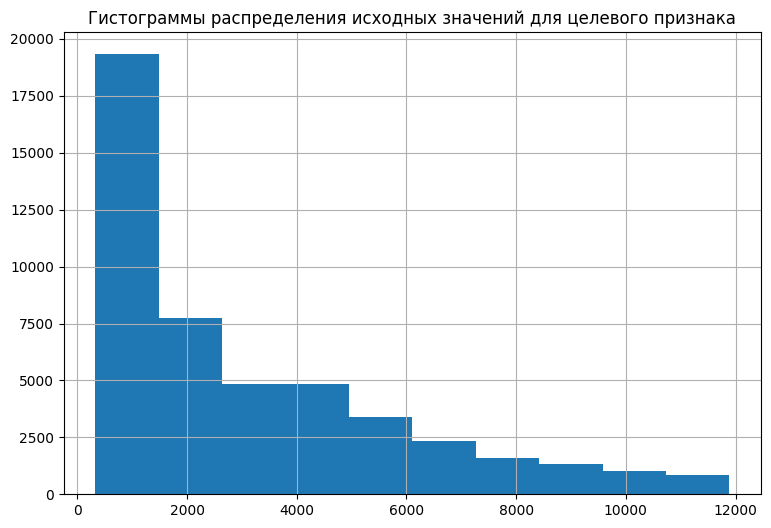

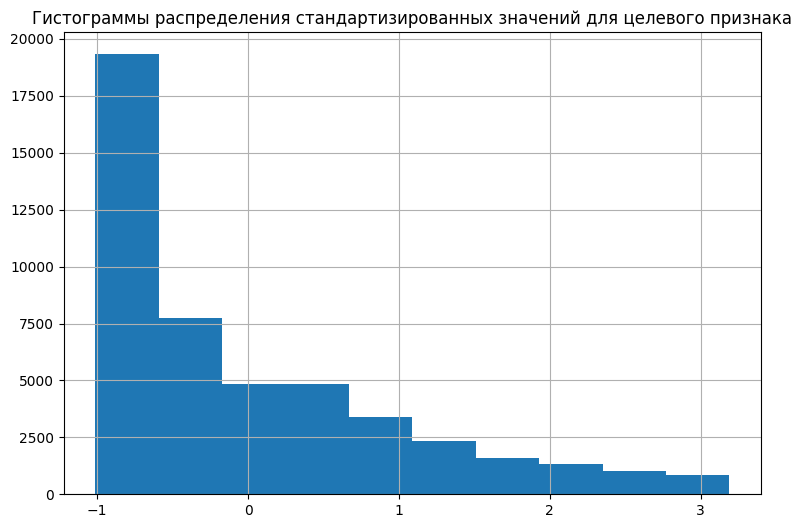

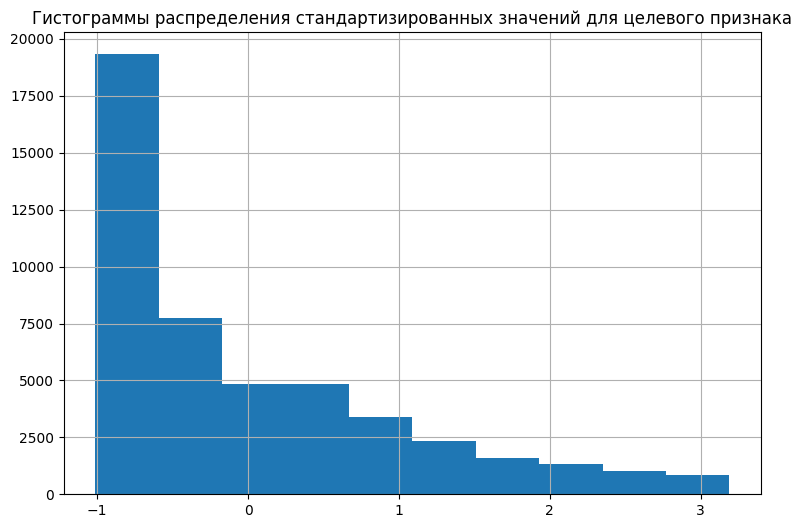

In [ ]:
plot_dfY(dfY)
plot_dfY(dfYStd)
plot_dfY(dfY_scaled)


In [ ]:
rand_seed = 8 # начальное состояние генератора случ. чисел
valid_size = 0.3 # доля тестовой части в выборке

In [ ]:
def split_by_seed(dfX, dfY, rand_seed):
  x_train, x_test, y_train, y_test =  train_test_split(
      dfX,    # исходные данные X
      dfY,      # исходные данные y
      test_size = valid_size, # доля тестовой части в выборке
      random_state=rand_seed, # начальное состояние генератора случ. чисел
      shuffle=True            # перемешивание
  )
  y_train = y_train['price']
  y_test = y_test['price']
  return x_train, x_test, y_train, y_test

##Данные

###НЕ Стандартизированные

In [ ]:
x_train, x_test, y_train, y_test =  split_by_seed(df[features], df[target], rand_seed)

print ("Кол-во элементов: \n  x_train: {}, y_train {} \n  x_test:  {}, y_test  {} \n  total x: {}, total y {} ".format  (
    len(x_train), len(y_train),
    len(x_test),  len(x_test),
    len(x_train)+len(x_test), len(y_train)+len(x_test),
))

Кол-во элементов: 
  x_train: 33128, y_train 33128 
  x_test:  14199, y_test  14199 
  total x: 47327, total y 47327 


###Стандартизированные

In [ ]:
xStd_train, xStd_test, yStd_train, yStd_test = split_by_seed(dfXStd, dfYStd, rand_seed)

print(xStd_train)
print(yStd_train)

          carat       cut     color   clarity     depth     table         x  \
42468 -0.993688 -1.981597 -0.869976 -0.076209  1.730742 -0.128401 -1.150047   
34150 -0.535629 -0.999750  0.317945 -1.293266  0.826176 -0.622932 -0.486695   
9315   1.000217 -1.981597  0.911906 -1.293266  1.730742 -0.128401  1.013501   
44313 -1.074522  0.963943 -0.276015 -0.076209 -0.078391 -1.117463 -1.221485   
26816 -1.101467  0.963943  0.911906  1.140848 -0.078391 -0.128401 -1.262306   
...         ...       ...       ...       ...       ...       ...       ...   
10376  0.946328 -0.999750  0.317945 -0.684738  0.464349 -0.622932  0.972679   
34949 -0.347016  0.963943 -1.463937 -1.293266 -0.440217 -0.622932 -0.170327   
18417  0.946328  0.963943 -0.276015  0.532320  0.464349 -1.117463  0.972679   
25940 -1.020633  0.963943  0.317945  1.140848 -0.982957 -0.622932 -1.109225   
4547   1.000217 -1.981597 -2.057898 -1.293266  1.278459  0.860660  0.870625   

              y         z  
42468 -1.141462 -1.0039

In [ ]:
def create_sgd_regressor(x_train, y_train) -> linear_model.SGDRegressor:
  # Модель стохастического градиентного спуска
  sgd_reg = linear_model.SGDRegressor(
      loss='squared_error', # Метод наименьших квадратов (Ordinary least squares)
      max_iter=10000,
      tol=1e-3,
      random_state=8,
  )
  sgd_reg.fit(x_train,  y_train)
  return sgd_reg

##Модель SGDRegressor

###НЕ стандартизированные

MAE : 5,254,150.290 (средняя абсолютная ошибка)
MSE : 217,814,868,474,641.875000 (среднеквадратичная ошибка)
RMSE: 14,758,552.384114 (кв. корень из среднеквадратичной ошибки)
R2  : -28,676,713.431 (коэфф. детерминации)


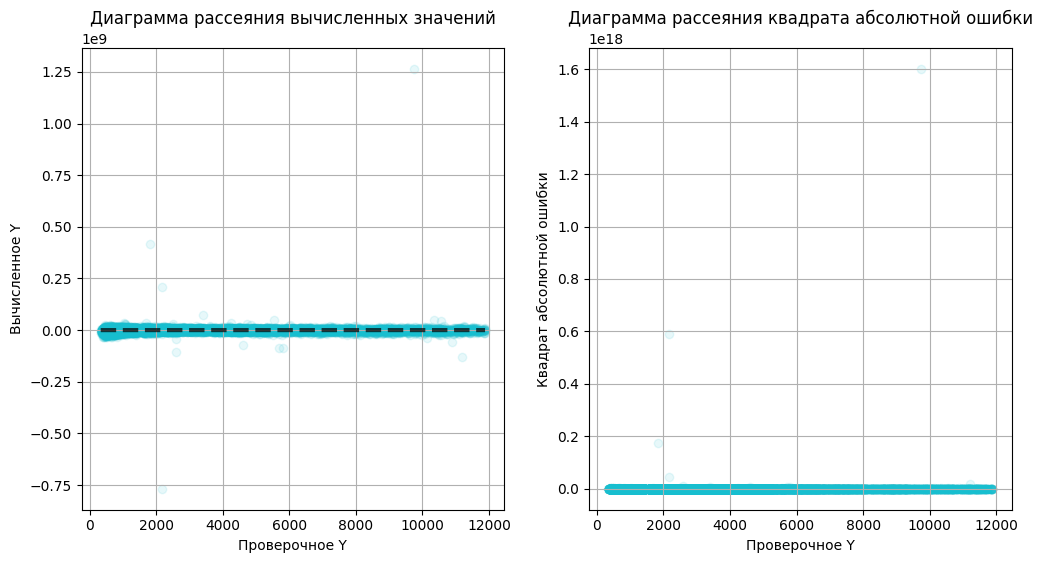

In [ ]:
sgd_reg_nonStd = create_sgd_regressor(x_train, y_train)
y_pred = sgd_reg_nonStd.predict(x_test)

draw_plot(y_test, y_pred)
print_metrics(y_test, y_pred)

### Стандартизированные

####Random seed = 24

MAE :   555.711 (средняя абсолютная ошибка)
MSE : 645,199.833677 (среднеквадратичная ошибка)
RMSE: 803.243322 (кв. корень из среднеквадратичной ошибки)
R2  :     0.913 (коэфф. детерминации)


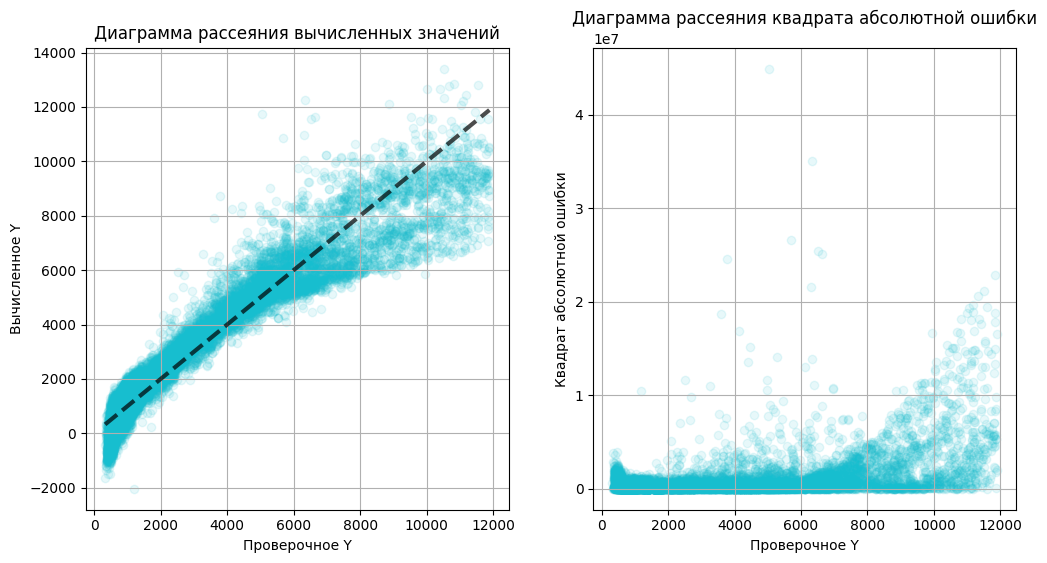

In [ ]:
random_seed = 24
xStd_train, xStd_test, yStd_train, yStd_test = split_by_seed(dfXStd, dfYStd, 24)

sgd_reg_std = create_sgd_regressor(xStd_train, yStd_train)
yStd_pred = sgd_reg_std.predict(xStd_test)

inversed_yStd_test = scalerStdY.inverse_transform([yStd_test])
inversed_yStd_pred = scalerStdY.inverse_transform([yStd_pred])

draw_plot(inversed_yStd_test, inversed_yStd_pred)
print_metrics(inversed_yStd_test, inversed_yStd_pred)

####Random seed = 7

MAE :   578.818 (средняя абсолютная ошибка)
MSE : 673,131.328067 (среднеквадратичная ошибка)
RMSE: 820.445811 (кв. корень из среднеквадратичной ошибки)
R2  :     0.912 (коэфф. детерминации)


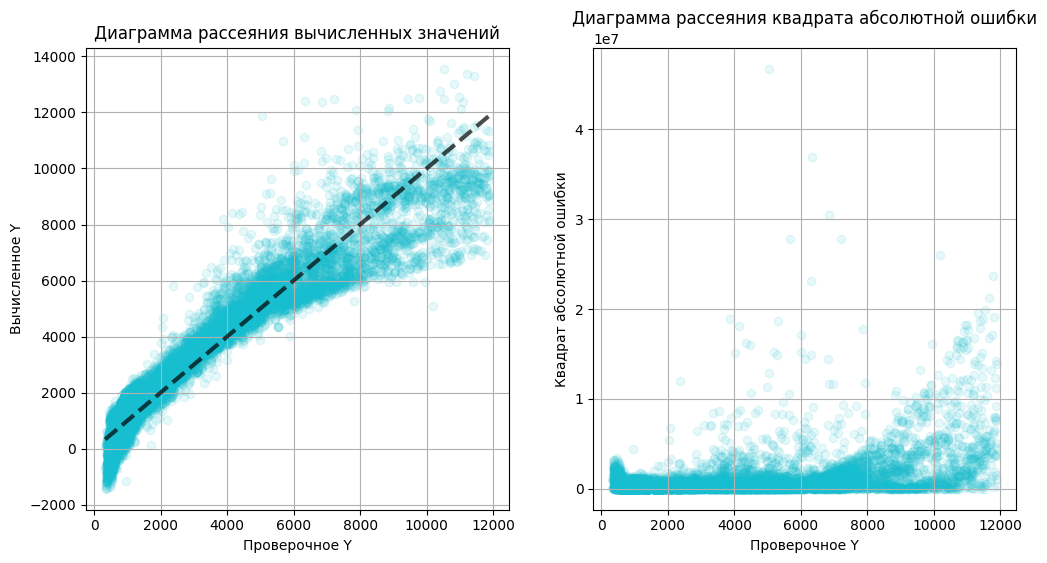

In [ ]:
random_seed = 7
xStd_train, xStd_test, yStd_train, yStd_test = split_by_seed(dfXStd, dfYStd, 7)

sgd_reg_std = create_sgd_regressor(xStd_train, yStd_train)
yStd_pred = sgd_reg_std.predict(xStd_test)

inversed_yStd_test = scalerStdY.inverse_transform([yStd_test])
inversed_yStd_pred = scalerStdY.inverse_transform([yStd_pred])

draw_plot(inversed_yStd_test, inversed_yStd_pred)
print_metrics(inversed_yStd_test, inversed_yStd_pred)

## Заключение по полученых результатам




Стандартизация данных оказала кардинальное влияние на качество модели SGDRegressor: при обучении на нестандартизованных данных модель полностью провалилась (R² ≈ −2.87·10⁷, RMSE ≈ 1.48·10⁷), выдавая предсказания, близкие к нулю, тогда как после стандартизации X и y даже при разных значениях random_state (24 и 7) модель показывает стабильно высокое качество: R² ≈ 0.912–0.913, RMSE ≈ 803–820. Незначительные колебания метрик (менее 2 %) говорят о том, что разбиение выборки слабо влияет на результат — модель устойчива и обобщающая способность надёжна. Это подчёркивает, что стандартизация не просто улучшает результативность SGD, но и обеспечивает стабильность оценок качества при разных случайных разбиениях, в отличие от нестандартизированного случая, где результаты непредсказуемы и катастрофичны.

## Кросс-валидация

In [ ]:
def kross_valid(x_test, y_test, scor):
    modelForCV =  linear_model.SGDRegressor(
    max_iter=10000,
    tol=1e-3,
    random_state=8,
    )
    scores_cross = cross_val_score(
                                        estimator = modelForCV, # Модель для обучения (вызова метода .fit())
                                        X=x_test,   # Независимые переменные
                                        y=y_test,   # Целевая переменная
                                        cv=3,       # Кол-во K-частей (Fold)
                                        scoring=scor# Режим расчитываемой метрики
                                )
    return scores_cross

In [ ]:
R2 = kross_valid(x_test, y_test, 'r2')
print(f"R2. Не стандартизированные проверочные данные", R2.mean())
RMSE = kross_valid(x_test, y_test, 'neg_root_mean_squared_error')
print(f"RMSE. Не стандартизированные проверочные данные", RMSE.mean())

R2. Не стандартизированные проверочные данные -1.7397387776972163e+17
RMSE. Не стандартизированные проверочные данные -1141673462281.1719


In [ ]:
R2_std = kross_valid(xStd_test, yStd_test, 'r2')
print(f"R2. Стандартизированные проверочные данные", R2_std.mean())
RMSE_std = kross_valid(xStd_test, yStd_test, 'neg_root_mean_squared_error')
print(f"RMSE. Стандартизированные проверочные данные", RMSE_std.mean())

R2. Стандартизированные проверочные данные 0.913342103684338
RMSE. Стандартизированные проверочные данные -0.294922823063767


Так как y стандартизирована через y = (y - μ) / σ и модель обучалась на y_std и предсказывала y_pred_std, RMSE можно перевести в единицы измерения исходной величины y.

In [ ]:
rmse_real = abs(RMSE_std.mean()) * scalerStdY.scale_[0]
print("RMSE в исходных единицах:", rmse_real)

RMSE в исходных единицах: 811.2642032932293
2750.7677936401046


## Заключение о величине коридора изменений оценок моделей

На основании полученных результатов можно сделать вывод, что величина коридора изменений оценок модели значительна, что указывает на высокую чувствительность модели к масштабу признаков.
При обучении на нестандартизированных данных модель демонстрирует крайне низкие показатели (R² отрицательный, RMSE огромный), что говорит о неустойчивости и неадекватной работе алгоритма.
После стандартизации наблюдается резкое улучшение метрик (R² ≈ 0.91, RMSE ≈ 811.264, что свидетельствует о корректной сходимости стохастического градиентного спуска.

# Итоговые, сводные результаты и выводы

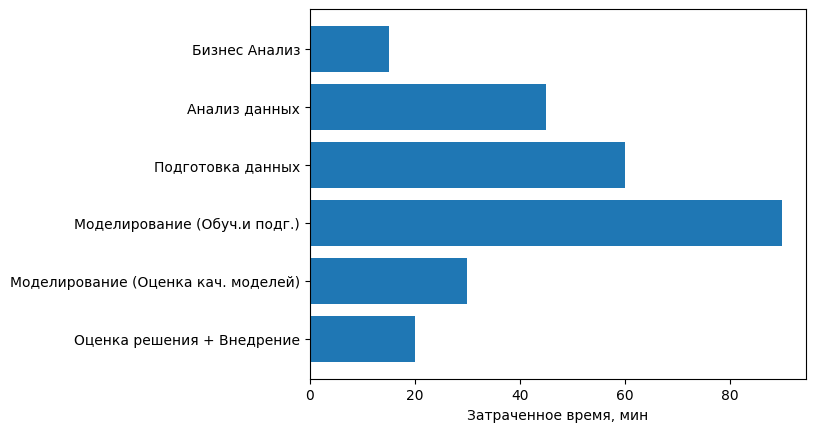

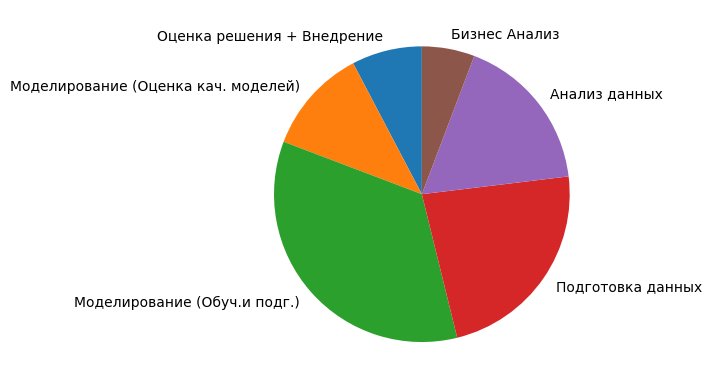

In [ ]:
dfSpendTimeLab2 = pd.DataFrame.from_dict(
{
  "1": {"step": "Бизнес Анализ",                       "duration, min" : 15  },
  "2": {"step": "Анализ данных",                       "duration, min" : 45  },
  "3": {"step": "Подготовка данных",                   "duration, min" : 60  },
  "4": {"step": "Моделирование (Обуч.и подг.)",        "duration, min" : 90  },
  "5": {"step": "Моделирование (Оценка кач. моделей)", "duration, min" : 30  },
  "6": {"step": "Оценка решения + Внедрение",          "duration, min" : 20  },
}
, orient="index"
).sort_index(ascending=False)

# Столбчатая диаграмма
fig = plt.figure()
plt.barh(y = dfSpendTimeLab2["step"], width= dfSpendTimeLab2["duration, min"], )
plt.xlabel("Затраченное время, мин")

# Круговая диаграмма
fig = plt.figure()
plt.pie(x= dfSpendTimeLab2["duration, min"], labels=dfSpendTimeLab2["step"],  startangle = 90 )

plt.show()